In [1]:
import pandas as pd

train = pd.read_csv("../data/processed/train.csv")
test = pd.read_csv("../data/processed/test.csv")


In [14]:
import sys
from pathlib import Path


project_dir = Path().resolve().parents[0]
sys.path.append(str(project_dir / "src"))

project_dir


PosixPath('/home/ahmed-khalid/fraud-detection')

In [15]:
from utils.preprocess import split_features_labels, scale_amount


# Split X and y
X_train, y_train = split_features_labels(train)
X_test, y_test   = split_features_labels(test)

# Scale Amount ONLY
X_train, scaler = scale_amount(X_train)
X_test["Amount"] = scaler.transform(X_test[["Amount"]])


1. Understand the basic performance of a simple linear model on the fraud dataset.
2. Measure how class imbalance affects prediction quality.
3. Check if the model can detect fraud (Class 1) without any sampling techniques.
4. Use F1-score of the fraud class as the main metric for evaluation.
5. Compare this baseline with future models (Random Forest, XGBoost, Neural Networks).
6. Identify limitations of linear models on non-linear and highly imbalanced data.


In [20]:
results = {}

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

log_reg = LogisticRegression(class_weight="balanced", max_iter=500)

log_reg.fit(X_train, y_train)

log_pred = log_reg.predict(X_test)
results["Logistic Regression"] = f1_score(y_test,log_pred )
print(classification_report(y_test, log_pred))
print("F1 Score:", f1_score(y_test, log_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.92      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

F1 Score: 0.0946372239747634


/home/ahmed-khalid/anaconda3/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Logistic Regression achieved very high recall (92%) for fraud but very low precision (5%).
- This means the model catches most fraud cases but makes many false alarms.
- Overall F1-score for fraud is low (0.09), which is expected due to class imbalance.
- Accuracy (97%) is misleading and not useful for this problem.
- A more powerful model and better class balancing will be required.


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
results["Random Forest"] = f1_score(y_test, rf_pred)
print(classification_report(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.8522727272727273


- Random Forest significantly outperforms Logistic Regression.
- Precision of fraud = 0.96 → very low false alarms.
- Recall of fraud = 0.77 → model catches 77% of fraud cases.
- F1-score = 0.85 → strong balance between precision and recall.
- Random Forest handles non-linear patterns and PCA features extremely well.
- This model is a strong baseline even before any resampling techniques.


In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,  # مهم جداً للـ imbalance
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
results["XGBoost"] = f1_score(y_test, xgb_pred)
print(classification_report(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.8645833333333334


- XGBoost achieved the best overall F1-score among the baseline models.
- It provides a strong balance between precision (0.88) and recall (0.85) for fraud.
- Unlike Logistic Regression, XGBoost handles non-linear patterns in PCA features effectively.
- Compared to Random Forest, XGBoost improved recall (85% vs 77%), detecting more fraud cases.
- XGBoost is a strong candidate for the final model even before applying SMOTE or threshold tuning.


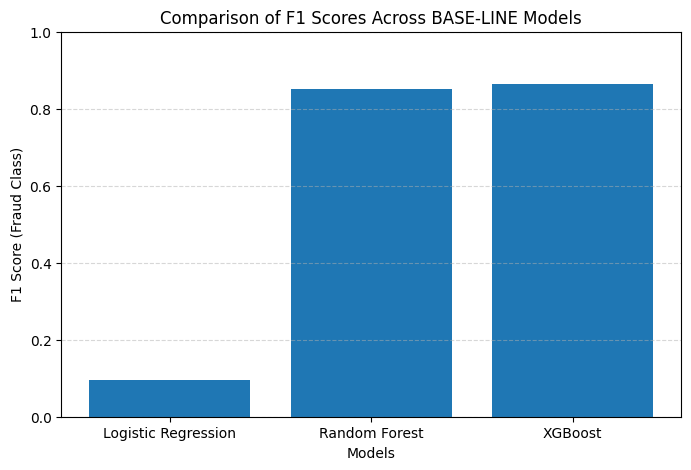

In [25]:
import matplotlib.pyplot as plt

models = list(results.keys())
f1_scores = list(results.values())

plt.figure(figsize=(8,5))
plt.bar(models, f1_scores)

plt.title("Comparison of F1 Scores Across BASE-LINE Models")
plt.xlabel("Models")
plt.ylabel("F1 Score (Fraud Class)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()
